# Questão 1
### Questão 1A — Definição de *feature* e necessidade de tratamento

**Feature** é um atributo coletado, uma variável preditora que representa um aspecto observado de um fenômeno-alvo, o alvo por outro lado é chamado "target". Em termos formais, cada feature é um componente de um vetor que alimenta o algoritmo de Machine Learning.

### Por que tratar features antes da modelagem?

1. **Escalas incompatíveis** – Distâncias e gradientes ficam distorcidos; resolve-se com normalização ou padronização.  
2. **Tipos incompatíveis** – Algoritmos numéricos não processam categorias brutas; emprega‐se *encoding* para dados qualitativos.  
3. **Dados ausentes e ruído** – Valores nulos (*NaN*) e outliers prejudicam a convergência; usa-se imputação e *robust scaling*.  
4. **Redundância e vazamento** – Variáveis colineares ou com informação futura causam *overfitting*; eliminam-se via análise de correlação ou pipelines bem definidos.

---

### Questão 1B — Seleção de features úteis

| Método      | Mecanismo                                                         | Quando usar                                  | Limitações                                                         |
|-------------|-------------------------------------------------------------------|----------------------------------------------|--------------------------------------------------------------------|
| **Filtragem** | Avalia cada feature isoladamente por estatísticas univariadas (teste qui-quadrado, ANOVA-F, informação mútua). | Datasets muito grandes; pré-poda rápida.      | Ignora interações e pode manter redundância.                       |
| **Wrapper**   | Testa subconjuntos treinando um modelo (RFE, *forward/backward selection*). | Conjuntos médios; busca desempenho máximo para um algoritmo específico. | Alto custo computacional; risco de *overfitting* se validação fraca. |
| **Embedding** | Seleção ocorre dentro do treinamento (Lasso, Árvores, mecanismos de atenção). | Dados de alta dimensão; modelos que já calculam importâncias. | Transparência reduzida; dependente do modelo escolhido.            |

**Estratégia recomendada**  
1. Aplicar filtragem para descartar irrelevâncias óbvias.  
2. Utilizar wrapper ou embedding para refinar de acordo com o algoritmo-alvo.  
3. Empregar validação cruzada para confirmar ganho de generalização.

---

### Questão 1C — Escalares, vetores e espaços vetoriais em ML

| Conceito            | Definição resumida                                                                                   | Exemplo em Machine Learning                                                    |
|---------------------|------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| **Escalar**         | Número real utilizado para ponderar vetores.                                                         | Taxa de aprendizagem (eta = 0,01) em *gradient descent*.                       |
| **Vetor**           | Sequência ordenada de escalares, representada como x = (x₁, …, xₙ).                                   | Vetor de 784 pixels (28 × 28) que descreve uma imagem no conjunto MNIST.       |
| **Espaço vetorial** | Conjunto V de vetores fechado sob adição e multiplicação por escalares, obedecendo a axiomas lineares.| O espaço R³⁰⁰ que contém todos os *word embeddings* de 300 dimensões (Word2Vec).|

Esses conceitos sustentam operações essenciais em ML, como cálculo de distâncias (distância Euclidiana entre vetores), projeções e otimização em espaços de alta dimensão.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, MinMaxScaler, StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline

In [ ]:
# ---------------------------------------------------------------
# Questão 2 — Breast Cancer Dataset
# ---------------------------------------------------------------


# Questão 2(a) — Identificar as features contínuas
# ---------------------------------------------------------------
dados = load_breast_cancer()
df = pd.DataFrame(dados.data, columns=dados.feature_names)

print("[2(a)] Identificação das features contínuas\n")
print(f"Dataset contém {df.shape[0]} amostras e {df.shape[1]} features contínuas.\n")

# Todas as 30 colunas deste dataset já são numéricas contínuas.
features_continuas = df.columns.tolist()
print("\n[2(a)] Features contínuas no dataset:")
for feat in features_continuas:
    print(f" • {feat}")

# ---------------------------------------------------------------
# Questão 2(b) — Discretização por bins fixos
# ---------------------------------------------------------------
# Selecionar duas features contínuas para o exemplo
features_selecionadas = ["mean radius", "mean texture"]
print("\n[2(b)] Discretização por bins fixos (4 intervalos de mesma largura)\n")

for coluna in features_selecionadas:
    # 4 intervalos de igual largura
    bins_fixos = pd.cut(df[coluna], bins=4, include_lowest=True)
    contagem_fixos = bins_fixos.value_counts(sort=False)

    print(f"--- {coluna} ---")
    print(contagem_fixos, "\n")

# ---------------------------------------------------------------
# Questão 2(c) — Discretização por bins variáveis (quantis)
# ---------------------------------------------------------------
print("[2(c)] Discretização por bins variáveis (quartis)\n")

for coluna in features_selecionadas:
    # 4 intervalos gerados pelos quartis (mesmo nº aproximado de amostras)
    bins_variaveis = pd.qcut(df[coluna], q=4, duplicates="drop")
    contagem_variaveis = bins_variaveis.value_counts(sort=False)

    print(f"--- {coluna} ---")
    print(contagem_variaveis, "\n")


[2(a)] Identificação das features contínuas

Dataset contém 569 amostras e 30 features contínuas.


[2(a)] Features contínuas no dataset:
 • mean radius
 • mean texture
 • mean perimeter
 • mean area
 • mean smoothness
 • mean compactness
 • mean concavity
 • mean concave points
 • mean symmetry
 • mean fractal dimension
 • radius error
 • texture error
 • perimeter error
 • area error
 • smoothness error
 • compactness error
 • concavity error
 • concave points error
 • symmetry error
 • fractal dimension error
 • worst radius
 • worst texture
 • worst perimeter
 • worst area
 • worst smoothness
 • worst compactness
 • worst concavity
 • worst concave points
 • worst symmetry
 • worst fractal dimension

[2(b)] Discretização por bins fixos (4 intervalos de mesma largura)

--- mean radius ---
mean radius
(6.959, 12.263]     191
(12.263, 17.545]    276
(17.545, 22.828]     90
(22.828, 28.11]      12
Name: count, dtype: int64 

--- mean texture ---
mean texture
(9.679, 17.102]     185
(17

In [45]:
# ---------------------------------------------------------------
#Questão 3 Breast Cancer Dataset — Normalização
# ---------------------------------------------------------------


# ---------------------------------------------------------------
# 3.A) Normalização personalizada via FunctionTransformer
#    (Min-Max Scaling 0-1)
# ---------------------------------------------------------------
def min_max_scaler(arr):
    """Aplica min-max scaling coluna a coluna."""
    mins = np.min(arr, axis=0)
    maxs = np.max(arr, axis=0)
    return (arr - mins) / (maxs - mins)

min_max_transformer = FunctionTransformer(min_max_scaler, feature_names_out=None)
X_minmax = pd.DataFrame(
    min_max_transformer.fit_transform(df.values),
    columns=dados.feature_names,
)

# Exibir estatísticas de verificação
print("\n[2.A] Estatísticas após Min-Max Scaling")
print(
    pd.DataFrame(
        {
            "min": X_minmax.min(),
            "max": X_minmax.max(),
            "mean": X_minmax.mean(),
            "std": X_minmax.std(ddof=0),
        }
    ).round(3)
)

# ---------------------------------------------------------------
# 3.B) Normalização via PowerTransform (Yeo-Johnson + padronização)
# ---------------------------------------------------------------
power = PowerTransformer(method="yeo-johnson", standardize=True)
X_power = pd.DataFrame(
    power.fit_transform(df.values),
    columns=dados.feature_names,
)

# Exibir estatísticas de verificação
print("\n[3.B] Estatísticas após PowerTransform (Yeo-Johnson)")
print(
    pd.DataFrame(
        {
            "mean": X_power.mean(),
            "std": X_power.std(ddof=0),
            "skewness": X_power.skew(),
        }
    ).round(3)
)



[2.A] Estatísticas após Min-Max Scaling
                         min  max   mean    std
mean radius              0.0  1.0  0.338  0.167
mean texture             0.0  1.0  0.324  0.145
mean perimeter           0.0  1.0  0.333  0.168
mean area                0.0  1.0  0.217  0.149
mean smoothness          0.0  1.0  0.395  0.127
mean compactness         0.0  1.0  0.261  0.162
mean concavity           0.0  1.0  0.208  0.187
mean concave points      0.0  1.0  0.243  0.193
mean symmetry            0.0  1.0  0.380  0.138
mean fractal dimension   0.0  1.0  0.270  0.149
radius error             0.0  1.0  0.106  0.100
texture error            0.0  1.0  0.189  0.122
perimeter error          0.0  1.0  0.099  0.095
area error               0.0  1.0  0.063  0.085
smoothness error         0.0  1.0  0.181  0.102
compactness error        0.0  1.0  0.174  0.134
concavity error          0.0  1.0  0.081  0.076
concave points error     0.0  1.0  0.223  0.117
symmetry error           0.0  1.0  0.178  0.116

In [46]:
# ---------------------------------------------------------------
# Questão 4 — Breast Cancer Dataset: Normalização, Escalonamento 
#             e Regularização
# ---------------------------------------------------------------

# ---------------------------------------------------------------
# 4(a) Min-Max Scaling (0 – 1)
# ---------------------------------------------------------------
minmax = MinMaxScaler()
X_minmax = pd.DataFrame(minmax.fit_transform(df), columns=dados.feature_names)

print("\n[4(a)] Estatísticas após Min-Max Scaling (0–1):")
print(
    pd.DataFrame(
        {
            "min": X_minmax.min(),
            "max": X_minmax.max(),
            "mean": X_minmax.mean(),
            "std": X_minmax.std(ddof=0),
        }
    ).round(3)
)

# ---------------------------------------------------------------
# 4(b) Standard Scaling (média 0, desvio-padrão 1)
# ---------------------------------------------------------------
std_scaler = StandardScaler()
X_std = pd.DataFrame(std_scaler.fit_transform(df), columns=dados.feature_names)

print("\n[4(b)] Estatísticas após Standard Scaling:")
print(
    pd.DataFrame(
        {
            "mean": X_std.mean(),
            "std": X_std.std(ddof=0),
            "min": X_std.min(),
            "max": X_std.max(),
        }
    ).round(3)
)

# ---------------------------------------------------------------
# 4(c) Regularização L2 (normalização por vetor linha)
# ---------------------------------------------------------------
# Normalizer aplica normalização L2 em cada amostra (linha), 
# resultando em vetores de norma 1.
X, y = load_breast_cancer(return_X_y=True)
l2_normalizer = Normalizer(norm="l2")
X_l2 = pd.DataFrame(l2_normalizer.fit_transform(X), columns=dados.feature_names)

# Conferir se a norma de cada vetor linha é 1
normas = np.linalg.norm(X_l2.values, ord=2, axis=1)
print("\n[4(c)] Verificação da norma L2 de cada amostra (deve ser 1.0):")
print(pd.Series(normas).describe().round(3))

# ---------------------------------------------------------------
# 4(d) Aplicação simultânea de transformações
# ---------------------------------------------------------------
pipe = make_pipeline(
    StandardScaler(),      # Escalonamento padrão
    Normalizer(norm="l2")  # Regularização L2 por amostra
)

# Ajusta ao conjunto de dados e transforma
X_transf = pipe.fit_transform(X)

# ---------------------------------------------------------------
# Comprovações rápidas
# ---------------------------------------------------------------
# 1. Norma L2 de cada amostra deve ser 1
normas = np.linalg.norm(X_transf, ord=2, axis=1)
print("Norma L2 mínima, média, máxima:", normas.min(), normas.mean(), normas.max())

# 2. As features foram padronizadas antes da normalização
#    (as médias após o passo L2 tendem a zero, mas não exatamente,
#     pois a normalização altera as escalas relativas)
print("Média das primeiras 5 features após transformação:",
      np.mean(X_transf, axis=0)[:5])
#
#Sim. As transformações podem ser encadeadas em um Pipeline do scikit-learn:
#from sklearn.pipeline import make_pipeline
#pipe = make_pipeline(
#    StandardScaler(),   # passo 1
#    Normalizer(norm="l2")  # passo 2
#)
#X_transf = pipe.fit_transform(X)
#A ordem importa: normalmente usa-se um escalonamento (MinMax ou Standard)
#seguido pela normalização L2 se o modelo exigir vetores de unidade (ex.
#k-NN baseado em similaridade de cosseno). A aplicação simultânea deve
#ser justificada pelo algoritmo ou pelo pré-processamento desejado.
#



[4(a)] Estatísticas após Min-Max Scaling (0–1):
                         min  max   mean    std
mean radius              0.0  1.0  0.338  0.167
mean texture             0.0  1.0  0.324  0.145
mean perimeter           0.0  1.0  0.333  0.168
mean area                0.0  1.0  0.217  0.149
mean smoothness          0.0  1.0  0.395  0.127
mean compactness         0.0  1.0  0.261  0.162
mean concavity           0.0  1.0  0.208  0.187
mean concave points      0.0  1.0  0.243  0.193
mean symmetry            0.0  1.0  0.380  0.138
mean fractal dimension   0.0  1.0  0.270  0.149
radius error             0.0  1.0  0.106  0.100
texture error            0.0  1.0  0.189  0.122
perimeter error          0.0  1.0  0.099  0.095
area error               0.0  1.0  0.063  0.085
smoothness error         0.0  1.0  0.181  0.102
compactness error        0.0  1.0  0.174  0.134
concavity error          0.0  1.0  0.081  0.076
concave points error     0.0  1.0  0.223  0.117
symmetry error           0.0  1.0  0.17

In [48]:
# ===============================================================
# Questão 5 — Large Movie Review Dataset (aclImdb)
# ===============================================================

import re
from pathlib import Path
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Baixar recursos do NLTK na primeira execução
nltk.download('stopwords')
nltk.download('wordnet')

# ============================================================
# FUNÇÃO PARA CARREGAR AS RESENHAS
# ============================================================
def carregar_resenhas(caminho_base: Path, subset: str = 'train') -> pd.DataFrame:
    """Lê resenhas do subset 'train' ou 'test' e devolve DataFrame
    com colunas: texto, alvo (1 = pos, 0 = neg)."""
    textos, rotulos = [], []
    for polaridade in ('pos', 'neg'):
        diretorio = caminho_base / subset / polaridade
        for arquivo in diretorio.glob('*.txt'):
            textos.append(arquivo.read_text(encoding='utf‑8'))
            rotulos.append(1 if polaridade == 'pos' else 0)
    return pd.DataFrame({'texto': textos, 'alvo': rotulos})


CAMINHO_BASE = Path(r'aclImdb')

df = carregar_resenhas(CAMINHO_BASE, subset='train')
print(f'Carregado {len(df)} resenhas do subset "train" (positivo/negativo).')
print(f'Total de resenhas carregadas: {len(df)}')
df.head()
# ============================================================
# 5(a) Pré-processamento de texto
# ============================================================
stop_words_en = set(stopwords.words('english'))

def remover_stopwords(texto: str) -> str:
    tokens = re.findall(r'[A-Za-z]+', texto.lower())
    filtrados = [tok for tok in tokens if tok not in stop_words_en]
    return ' '.join(filtrados)
print('5(a) Pré-processamento de texto\n')
print('Ok')
df['texto_sem_stop'] = df['texto'].apply(remover_stopwords)
df[['texto_sem_stop']].head()


# ============================================================
# 5(b) Aplicar Stemming
# ============================================================

port_stemmer = PorterStemmer()

def aplicar_stemming(texto: str) -> str:
    return ' '.join(port_stemmer.stem(tok) for tok in texto.split())

df['texto_stem'] = df['texto_sem_stop'].apply(aplicar_stemming)
df[['texto_stem']].head()


# ============================================================
# Questão 5c – Aplicar *Lemmatization*
# ============================================================

lemmatizer = WordNetLemmatizer()

def aplicar_lemmatization(texto: str) -> str:
    return ' '.join(lemmatizer.lemmatize(tok) for tok in texto.split())

df['texto_lemma'] = df['texto_sem_stop'].apply(aplicar_lemmatization)
df[['texto_lemma']].head()

# ============================================================
# 5(d) Vetorização  Bag‑of‑Words
# ============================================================
vetorizador_bow = CountVectorizer(max_features=10000)  # limite opcional para velocidade
X_bow = vetorizador_bow.fit_transform(df['texto_stem'])

print('5(d) Vetorização Bag-of-Words\n')
print('Shape da matriz BoW:', X_bow.shape)
print('Algumas features:', vetorizador_bow.get_feature_names_out()[:20])

# ============================================================
# 5(e) 5e – Vetorização Bag‑of‑n‑Grams (bigramas)
# ============================================================
vetorizador_bigram = CountVectorizer(ngram_range=(2, 2), max_features=20000)
X_bigram = vetorizador_bigram.fit_transform(df['texto_lemma'])


print('5(e) Vetorização Bag-of-n-Grams (bigramas)\n')
print('Shape da matriz de bigramas:', X_bigram.shape)
print('Alguns bigramas:', vetorizador_bigram.get_feature_names_out()[:20])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Afect\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Afect\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Carregado 25000 resenhas do subset "train" (positivo/negativo).
Total de resenhas carregadas: 25000
5(a) Pré-processamento de texto

Ok
5(d) Vetorização Bag-of-Words

Shape da matriz BoW: (25000, 10000)
Algumas features: ['aag' 'aaron' 'ab' 'abandon' 'abbey' 'abbi' 'abbot' 'abbott' 'abc'
 'abduct' 'abe' 'abhay' 'abhorr' 'abid' 'abigail' 'abil' 'abl' 'abli'
 'aboard' 'abomin']
5(e) Vetorização Bag-of-n-Grams (bigramas)

Shape da matriz de bigramas: (25000, 20000)
Alguns bigramas: ['abbott costello' 'ability make' 'able capture' 'able enjoy' 'able find'
 'able get' 'able keep' 'able make' 'able see' 'able sit' 'able take'
 'able watch' 'abraham lincoln' 'absolute worst' 'absolutely amazing'
 'absolutely awful' 'absolutely beautiful' 'absolutely brilliant'
 'absolutely fantastic' 'absolutely hilarious']


In [ ]:
# ============================================================
# Questão 6 Large Movie Review Dataset
# ============================================================

import re
from pathlib import Path
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

# ---------- CONFIGURAÇÕES ----------
DATA_DIR = Path(r"aclImdb")
MAX_FEATURES = 50_000     # vocabulário TF-IDF
RANDOM_STATE = 42
nltk.download("stopwords", quiet=True)
STOP_EN = set(stopwords.words("english"))

# ---------- FUNÇÕES AUXILIARES ----------
def carregar_resenhas(base: Path, subset: str) -> pd.DataFrame:
    textos, rotulos = [], []
    for polar in ("pos", "neg"):
        pasta = base / subset / polar
        for arq in pasta.glob("*.txt"):
            textos.append(arq.read_text(encoding="utf8"))
            rotulos.append(1 if polar == "pos" else 0)
    return pd.DataFrame({"texto": textos, "alvo": rotulos})

TOKEN_RE = re.compile(r"[A-Za-z]+")

def limpar(texto: str) -> str:
    toks = TOKEN_RE.findall(texto.lower())
    return " ".join(tok for tok in toks if tok not in STOP_EN)

# ---------- CARGA E LIMPEZA ----------
df_train = carregar_resenhas(DATA_DIR, "train")
df_test  = carregar_resenhas(DATA_DIR, "test")
df_train["clean"] = df_train["texto"].apply(limpar)
df_test["clean"]  = df_test["texto"].apply(limpar)

print(f"Treino: {df_train.shape[0]} resenhas — Teste: {df_test.shape[0]} resenhas")

# ============================================================
# 6a) Vetorização TF-IDF
# ============================================================
tfidf = TfidfVectorizer(max_features=MAX_FEATURES)
X_train = tfidf.fit_transform(df_train["clean"])
X_test  = tfidf.transform(df_test["clean"])
y_train, y_test = df_train["alvo"], df_test["alvo"]

print("Shape TF-IDF (treino):", X_train.shape)
print("Algumas features:", tfidf.get_feature_names_out()[:15])

# ============================================================
# 6b) Classificador Regressão Logística
# ============================================================
clf = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# ---------- MÉTRICAS ----------
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("\n===== Desempenho =====")
print(f"Acurácia  : {acc:.3f}")
print(f"Precisão  : {prec:.3f}")
print(f"Recall    : {rec:.3f}")
print(f"F1-score  : {f1:.3f}")

print("\n===== Relatório detalhado =====")
print(classification_report(y_test, y_pred, digits=3))

print("===== Matriz de confusão =====")
print(confusion_matrix(y_test, y_pred))



Treino: 25000 resenhas — Teste: 25000 resenhas
Shape TF-IDF (treino): (25000, 50000)
Algumas features: ['aa' 'aaa' 'aaaaatch' 'aaaahhhhhhh' 'aaaand' 'aaaarrgh' 'aaah' 'aaargh'
 'aaaugh' 'aaawwwwnnn' 'aachen' 'aada' 'aadha' 'aag' 'aage']

===== Desempenho =====
Acurácia  : 0.883
Precisão  : 0.883
Recall    : 0.883
F1-score  : 0.883

===== Relatório detalhado =====
              precision    recall  f1-score   support

           0      0.883     0.883     0.883     12500
           1      0.883     0.883     0.883     12500

    accuracy                          0.883     25000
   macro avg      0.883     0.883     0.883     25000
weighted avg      0.883     0.883     0.883     25000

===== Matriz de confusão =====
[[11041  1459]
 [ 1457 11043]]


In [ ]:
## ============================================================
# Questão 7 — Large Movie Review Dataset
# ============================================================
import pandas as pd
from pathlib import Path

# 7a) Ler CSV e encontrar categóricas
df = pd.read_csv(Path("meets.csv"))
cat_cols = df.select_dtypes(include="object").columns.tolist()

# 7b) One-Hot
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=False)
print("Shape One-Hot:", df_onehot.shape)

# 7c) Dummy
df_dummy = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("Shape Dummy :", df_dummy.shape)

# 7d) Effect Coding — abordagem vetorial
def effect_encode(df, cat_cols):
    dummies = pd.get_dummies(df[cat_cols], dtype="int8")
    out = []
    for var in cat_cols:
        cols = [c for c in dummies.columns if c.startswith(f"{var}_")]
        base = cols[-1]            # categoria-referência
        k_minus_1 = cols[:-1]      # colunas mantidas
        enc = dummies[k_minus_1].copy()
        enc.loc[dummies[base] == 1, :] = -1  # linhas da referência → −1
        out.append(enc)
    return pd.concat([df.drop(columns=cat_cols).reset_index(drop=True), *out], axis=1)

df_effect = effect_encode(df, cat_cols)
print("Shape Effect:", df_effect.shape)

# Resumo
print(
    {
        "Original": df.shape[1],
        "One-Hot": df_onehot.shape[1],
        "Dummy": df_dummy.shape[1],
        "Effect": df_effect.shape[1],
    }
)


Shape One-Hot: (8482, 18076)
Shape Dummy : (8482, 18069)
Shape Effect: (8482, 18069)
{'Original': 8, 'One-Hot': 18076, 'Dummy': 18069, 'Effect': 18069}


# Questão 8  Vantagens e Desvantagens de se realizar a vetorização de variáveis categóricas de um dataset.

| Aspecto                                 | Vantagens                                                                                                                                                                                  | Desvantagens                                                                                                                                                                                             |
| --------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Compatibilidade algorítmica**         | Transforma valores nominais em representações numéricas diretamente utilizáveis por modelos estatísticos e de *machine learning* (regressões, SVM, redes neurais, K-means, etc.).          | Procedimentos de vetorização mal escolhidos podem introduzir colinearidade, distorcer distâncias ou induzir viés, afetando a robustez dos modelos.                                                       |
| **Capacidade preditiva**                | Técnicas como One-Hot, *target*-/count-encoding ou embeddings permitem que o algoritmo capture relações não lineares entre categorias e a variável-alvo, muitas vezes elevando a acurácia. | Codificações densas (One-Hot) geram matrizes esparsas muito grandes quando a cardinalidade é alta, aumentando tempo de treino, uso de RAM e risco de *overfitting* em categorias raras.                  |
| **Flexibilidade de representação**      | Disponibilidade de diversos esquemas (Dummy, Effect, Hashing, Embeddings) possibilita adaptar a codificação ao tipo de modelo e ao volume de dados.                                        | Métodos compactos (Hashing, Embeddings) reduzem interpretabilidade: cada dimensão deixa de ter significado semântico direto, dificultando a explicação de resultados.                                    |
| **Generalização a categorias inéditas** | Codificações como Feature Hashing ou Bucketização podem acomodar valores não vistos no treinamento, mantendo o sistema operacional em produção sem re-treinamento imediato.                | Hashing introduz colisões inevitáveis; Bucketização pode agrupar categorias heterogêneas, ocasionando perda de granularidade e queda de desempenho em cenários sensíveis.                                |
| **Integração com variáveis numéricas**  | Permite combinar, em um mesmo vetor de entrada, atributos contínuos e categóricos, favorecendo abordagens holísticas em modelagens preditivas.                                             | Se a projeção vetorial não preservar estatísticas relevantes da distribuição original (frequência, ordem, hierarquia), o modelo pode interpretar relações artificiais e produzir estimativas enviesadas. |


In [ ]:
# ------------------------------------------------------------
# 8a  Feature Hashing   •   8b  Bin Counting   •   8c  Comparação
# ------------------------------------------------------------

from pathlib import Path
from sklearn.feature_extraction import FeatureHasher
from sys import getsizeof

CSV = Path("meets.csv")
N_HASH_FEATS = 2 ** 12

# ------------------------------------------------------------
# 1. Ler base e separar variáveis categóricas
# ------------------------------------------------------------
df = pd.read_csv(CSV)
cat_cols = df.select_dtypes("object").columns.tolist()
print("Categóricas:", cat_cols)

# Constrói lista de dicionários {coluna: valor} – 1 por linha
dict_rows = df[cat_cols].astype(str).to_dict(orient="records")

# ------------------------------------------------------------
# 8a) Feature Hashing
# ------------------------------------------------------------
hasher = FeatureHasher(n_features=N_HASH_FEATS, input_type="dict", dtype=np.int8)
X_hash = hasher.transform(dict_rows)           # matriz esparsa csr
print("Hash shape:", X_hash.shape)

# ------------------------------------------------------------
# 8b) Bin Counting  (count-encoding por frequência global)
# ------------------------------------------------------------
df_count = df[cat_cols].copy()

df_count = df[cat_cols].copy()

for c in cat_cols:
    freq = df[c].value_counts(dropna=False)  # conta inclusive NaN
    df_count[c] = (
        df[c].map(freq)       # mapeia frequência
              .fillna(0)      # garante inteiro para valores ausentes
              .astype(np.int32)
    )
print("Count shape:", df_count.shape)

# ------------------------------------------------------------
# 8c) Comparação de tamanho na memória
# ------------------------------------------------------------
mem_hash  = (X_hash.data.nbytes + X_hash.indptr.nbytes + X_hash.indices.nbytes) / 1024**2
mem_count = df_count.memory_usage(deep=True).sum() / 1024**2
print(f"Memória  Hashing  : {mem_hash:6.2f} MB")
print(f"Memória  Counting : {mem_count:6.2f} MB")


Categóricas: ['MeetPath', 'Federation', 'Date', 'MeetCountry', 'MeetState', 'MeetTown', 'MeetName']
Hash shape: (8482, 4096)
Count shape: (8482, 7)
Memória  Hashing  :   0.32 MB
Memória  Counting :   0.23 MB



# Projeção Linear e Análise de Componentes Principais (PCA)

## 9a O que é uma projeção linear?

Uma projeção linear consiste em transformar vetores de um espaço de dimensão maior para um subespaço de menor dimensão por meio de operações exclusivamente lineares. Em termos práticos, escolhem‑se eixos diretores em um plano (ou hiperplano) de interesse e projetam‑se todos os pontos do conjunto de dados sobre esses eixos. A essência do processo é preservar relações lineares: se dois vetores originais se combinam por adição ou multiplicação escalar, as suas imagens projetadas manterão essa combinação de forma consistente. O resultado é uma representação mais compacta, porém ainda alinhada com a estrutura geométrica subjacente.

## 9b Como uma projeção linear é aplicada a um espaço de dados?

1. **Definição do subespaço‑alvo**  
   Determina‑se o plano ou hiperplano que melhor descreve a informação relevante — por exemplo, aquele em que se concentra a maior variação dos dados ou aquele que facilita a visualização.

2. **Construção da matriz de transformação**  
   Selecionam‑se vetores base que formam esse subespaço e organizam‑se em uma matriz. Cada coluna (ou linha, conforme a convenção adotada) é um eixo da nova base.

3. **Aplicação da transformação**  
   Cada ponto do conjunto de dados original é multiplicado pela matriz para obter suas novas coordenadas, agora expressas no subespaço desejado.

4. **Utilização dos vetores projetados**  
   Os dados transformados — mais compactos — podem ser utilizados em tarefas de visualização, aprendizado de máquina ou análise estatística, com menor custo computacional e, muitas vezes, maior robustez.

## 9c Passos executados pelo PCA para extrair componentes principais e reduzir a dimensionalidade

1. **Centralização dos dados**  
   Subtrai‑se a média de cada atributo, garantindo que o centro do conjunto de dados esteja na origem do sistema de coordenadas. Essa etapa evita que deslocamentos de escala influenciem a variância.

2. **Cálculo da matriz de covariância**  
   Avalia‑se como cada par de atributos varia conjuntamente. A matriz de covariância resume essas relações de dependência linear.

3. **Decomposição espectral ou SVD**  
   A matriz de covariância é decomposta em autovalores e autovetores (ou, alternativamente, a matriz centralizada é decomposta via Singular Value Decomposition).  
   * Os **autovetores** definem direções ortogonais que apontam para “onde” ocorre a maior variação.  
   * Os **autovalores** indicam “quanto” de variância existe em cada direção.

4. **Ordenação e seleção das componentes**  
   Ordena‑se os autovalores do maior para o menor e escolhe‑se um número k de componentes que capture uma fração satisfatória da variância total — por exemplo, 95 %. Esses k autovetores formam a nova base.

5. **Projeção dos dados**  
   Multiplica‑se a matriz dos dados centralizados pela matriz formada pelos k autovetores selecionados. Obtém‑se um conjunto de dados em k dimensões, contendo a maior parte da informação original.

6. **(Opcional) Reconstrução e avaliação de perda**  
   É possível reconstruir uma aproximação dos dados originais a partir das componentes principais e comparar com o conjunto original, mensurando a informação perdida durante a redução de dimensionalidade.


Componentes para ≥95 % de variância: 15


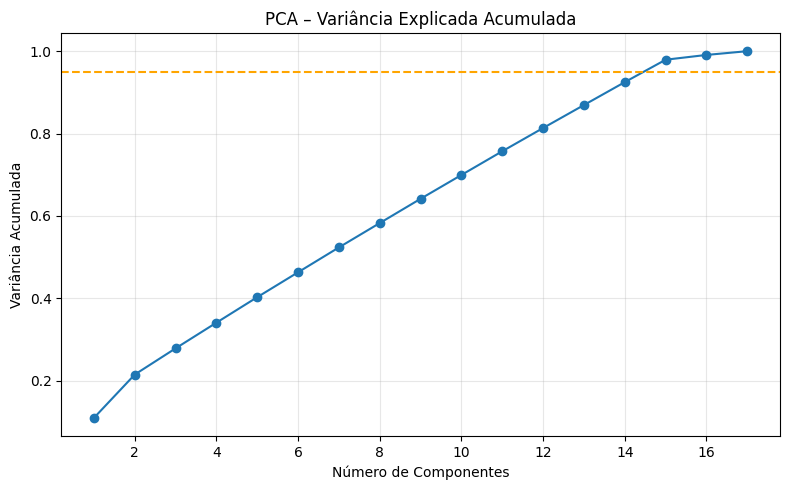

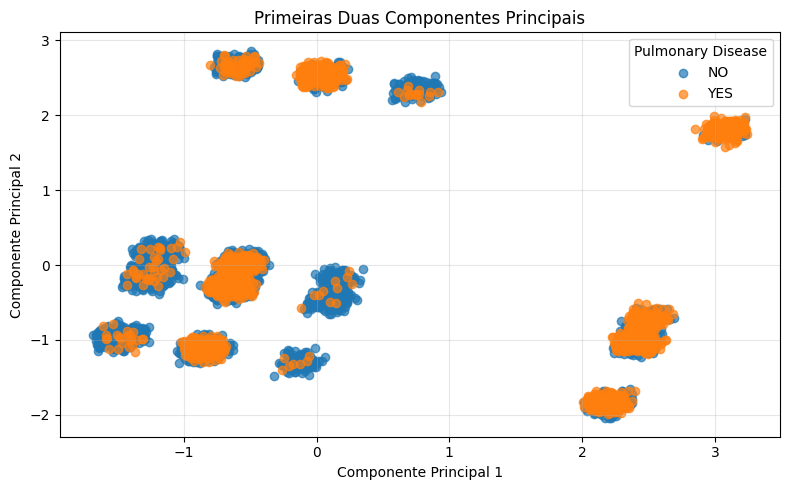

In [49]:
# ------------------------------------------------------------
# Questão 9 PCA no dataset “Lung Cancer Dataset.csv”
# ------------------------------------------------------------


import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

DATA_PATH = Path("Lung Cancer Dataset.csv")
df = pd.read_csv(DATA_PATH)


X = df.drop(columns=["PULMONARY_DISEASE"])
y = df["PULMONARY_DISEASE"]

# ---------------------------------------------------------------------
# 2. Padronizar as features numéricas
# ---------------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------------------
# 3. Rodar PCA completo
# ---------------------------------------------------------------------
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

# Quantas componentes atingem ≥ 95 % da variância?
k_95 = np.argmax(cum_explained >= 0.95) + 1
print(f"Componentes para ≥95 % de variância: {k_95}")

# ---------------------------------------------------------------------
# 4. Gráfico de variância acumulada
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(cum_explained) + 1),
    cum_explained,
    marker="o",
    linestyle="-",
)
plt.axhline(0.95, color="orange", linestyle="--")
plt.title("PCA – Variância Explicada Acumulada")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Acumulada")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 5. Dispersão das duas primeiras componentes
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 5))
labels = y.unique()
for label in labels:
    mask = y == label
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        label=label,
        alpha=0.7,
    )

plt.title("Primeiras Duas Componentes Principais")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Pulmonary Disease")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# Questão 11 PCA, Whitening e Seleção do Número de Componentes

## 11 a . Relação entre **Whitening** e **PCA**

* **Whitening** é um procedimento de transformação linear que produz um novo conjunto de variáveis com **variância unitária** e **covariância nula** — isto é, os dados resultantes estão *decorrelacionados* e *padronizados*.  
* O **PCA** fornece a base ortogonal que diagonaliza a matriz de covariância dos dados. Se, após calcular o PCA, **dividimos cada componente principal pelo desvio‑padrão associado** (raiz do respectivo autovalor), obtemos vetores de variância 1.  
* Assim, o whitening pode ser visto como **“PCA + escala”**:  
  1. Centra‑se o conjunto de dados.  
  2. Projeta‑se nos autovetores do PCA (decorrelaciona).  
  3. Divide‑se cada eixo pela raiz do autovalor correspondente (normaliza variância para 1).  

Essa combinação preserva a orientação de maior variabilidade (definida pelo PCA) ao mesmo tempo em que iguala a influência de cada direção, tornando o conjunto de dados isotrópico em termos de variância.

## 11 b. Como escolher o número de componentes principais usando a “curva de carga” (Scree Plot)

A curva de carga — também chamada de **scree plot** — apresenta os autovalores (ou a variância explicada) em ordem decrescente. O objetivo é identificar um ponto em que o ganho adicional de variância justifique (ou não) a inclusão de componentes extras.

**Procedimento sistemático:**

1. **Calcular autovalores ou variância explicada**  
   Após centralizar os dados, realiza‑se o PCA e ordenam‑se os autovalores do maior para o menor.

2. **Construir a curva**  
   Plota‑se no eixo X o índice da componente (1, 2, 3…) e no eixo Y o valor do autovalor ou a variância explicada associada.

3. **Identificar o “cotovelo”**  
   Observa‑se onde a curva perde inclinação de forma acentuada. Esse ponto indica que as componentes subsequentes contribuem pouco para a variância total.

4. **Definir critério de corte**  
   * **Elbow (cotovelo):** seleciona‑se o número de componentes no ponto imediatamente antes da queda brusca.  
   * **Variância acumulada:** calcula‑se a soma cumulativa da variância explicada e escolhe‑se o menor número de componentes que atinja um limiar definido (por exemplo, 90 % ou 95 %).  
   * **Teste paralelo ou Kaiser:** opcionalmente, compara‑se cada autovalor com autovalores de matrizes aleatórias ou usa‑se o critério Kaiser (manter autovalores > 1, se os dados foram padronizados).

5. **Validar na prática**  
   Finalmente, avalia‑se o desempenho do modelo ou da tarefa de interesse (classificação, clustering, reconstrução) usando o subconjunto escolhido. Caso o desempenho se estabilize ou melhore marginalmente, o número definido é considerado adequado.

Em síntese, a curva de carga facilita a visualização da **diminuição marginal de variância** explicada por cada componente, permitindo um balanço entre simplificação do modelo e preservação de informação.
